In [1]:
#1. Импорт и анализ таблиц
#Импортируйте данные в окружение Jupyter Notebook.

import pandas as pd

df = pd.read_excel("Новый датасет.xlsx", sheet_name=None)

orders  = df["Данные"]
clients = df["Clients"]
regions = df["Region_dict"]

display(orders.head())
display(clients.head())
display(regions.head())

orders.shape, clients.shape, regions.shape

,id_order,id_client,amt_payment,dtime_pay
0,100238,194569.0,5373.0,2022-10-28 04:05:15.221
1,100242,191056.0,4151.0,2022-08-01 02:42:54.992
2,100249,200049.0,5688.0,2022-08-24 12:45:12.744
3,100258,206161.0,4330.0,2022-12-09 15:13:26.437
4,100267,190945.0,5488.0,2022-08-03 02:07:31.468


,id_client,dtime_ad,nflag_test,id_trading_point
0,180844,2022-06-08 18:38:41.414,0,212
1,193942,NaT,0,13
2,226069,2022-07-11 16:28:38.511,1,54
3,183981,2022-06-16 12:23:59.289,1,991
4,322530,2022-07-08 08:56:08.714,0,1015


,id_trading_point,city
0,1,Петрозаводск
1,2,Дмитров
2,4,Чехов
3,7,Ростов Великий
4,11,Владимир


((37989, 4), (55605, 4), (66, 2))

In [2]:
#Изучите все три таблицы и проверьте их на наличие пустых значений.

na_report = {
    "orders": orders.isna().sum(),
    "clients": clients.isna().sum(),
    "regions": regions.isna().sum()
}

pd.DataFrame(na_report)

,orders,clients,regions
amt_payment,2144.0,NaN,NaN
city,NaN,NaN,0.0
dtime_ad,NaN,249.0,NaN
dtime_pay,2429.0,NaN,NaN
id_client,588.0,0.0,NaN
id_order,0.0,NaN,NaN
id_trading_point,NaN,0.0,0.0
nflag_test,NaN,0.0,NaN


Удаляем строки, где нет ключевых идентификаторов (id_order, id_client, id_trading_point, nflag_test).
Удаляем строки, где нет суммы платежа (amt_payment).
Сохраняем строки, где нет даты (dtime_pay, dtime_ad).
    **Таким образом, мы не теряем ценные данные о платежах и клиентах, но при этом избегаем искажения статистики.**

In [3]:
# 3. Очистка нуллов (сохраняем NaT в dtime_pay и dtime_ad)

orders_c  = orders.dropna(subset=["id_order", "id_client", "amt_payment"]).copy()
clients_c = clients.dropna(subset=["id_client", "nflag_test", "id_trading_point"]).copy()
regions_c = regions.dropna(subset=["id_trading_point", "city"]).copy()

# приведение ключей к int64
orders_c["id_client"] = orders_c["id_client"].astype("int64")
clients_c[["id_client","nflag_test","id_trading_point"]] = clients_c[["id_client","nflag_test","id_trading_point"]].astype("int64")
regions_c["id_trading_point"] = regions_c["id_trading_point"].astype("int64")

orders_c.shape, clients_c.shape, regions_c.shape


((35845, 4), (55605, 4), (66, 2))

После очистки:
orders_c (Данные о покупках) = (35845, 4)
35 845 строк и 4 столбца.
**Было 37 989 строк, я удалил 2144 (без суммы платежа) + 588 (без клиента) = часть пересекалась, итог осталось 35845 строк.**

В каждой строке есть id_order, id_client, amt_payment. В dtime_pay всё ещё могут быть пропуски, но я решил их оставить.
clients_c (Клиенты) = (55605, 4)
55 605 строк и 4 столбца.
**Здесь не было критичных пропусков в ключевых полях (кроме dtime_ad, оставлены).**

**Итог: осталось столько же строк, сколько и было.**
regions_c (Справочник регионов) = (66, 2)
66 строк и 2 столбца.

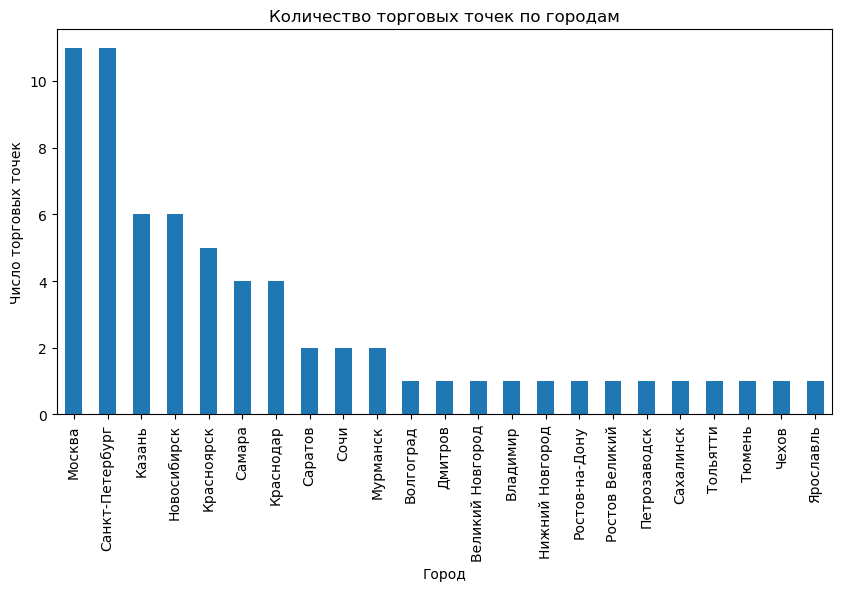

In [4]:
# 4. Исследуйте количество торговых точек в каждом городе 
# постройте группировку по количеству в каждом городе и визуализируйте с помощью столбчатой диаграммы.

import matplotlib.pyplot as plt

tp_per_city = regions_c.groupby("city")["id_trading_point"].nunique().sort_values(ascending=False)

tp_per_city.head(10)  # топ-10 городов по числу ТТ

plt.figure(figsize=(10,5))
tp_per_city.plot(kind="bar")
plt.title("Количество торговых точек по городам")
plt.ylabel("Число торговых точек")
plt.xlabel("Город")
plt.xticks(rotation=90)
plt.show()


In [5]:
# 2.1. Агрегация заказов по клиенту: сумма платежей и количество заказов

agg_orders = orders_c.groupby("id_client").agg(
    sum_payment=("amt_payment", "sum"),
    n_orders=("id_order", "count")
).reset_index()

agg_orders.head()


,id_client,sum_payment,n_orders
0,178561,3052.0,1
1,178562,2439.0,1
2,178563,768.0,1
3,178565,958.0,1
4,178566,5474.0,1


In [6]:
# 2.2. Соединяем агрегацию платежей с таблицей клиентов (LEFT JOIN)
ab_base = clients_c.merge(agg_orders, on="id_client", how="left")


clients_c.shape, ab_base.shape
ab_base.head()


,id_client,dtime_ad,nflag_test,id_trading_point,sum_payment,n_orders
0,180844,2022-06-08 18:38:41.414,0,212,5349.0,1.0
1,193942,NaT,0,13,4144.0,1.0
2,226069,2022-07-11 16:28:38.511,1,54,NaN,NaN
3,183981,2022-06-16 12:23:59.289,1,991,6322.0,2.0
4,322530,2022-07-08 08:56:08.714,0,1015,NaN,NaN


In [7]:
# 2.3. Заполняем NaN в сумме покупок и числе заказов нулями
ab_base[["sum_payment", "n_orders"]] = ab_base[["sum_payment", "n_orders"]].fillna(0)

ab_base.head()


,id_client,dtime_ad,nflag_test,id_trading_point,sum_payment,n_orders
0,180844,2022-06-08 18:38:41.414,0,212,5349.0,1.0
1,193942,NaT,0,13,4144.0,1.0
2,226069,2022-07-11 16:28:38.511,1,54,0.0,0.0
3,183981,2022-06-16 12:23:59.289,1,991,6322.0,2.0
4,322530,2022-07-08 08:56:08.714,0,1015,0.0,0.0


In [8]:
# 2.4. Подтягиваем название города по id_trading_point
ab_base = ab_base.merge(regions_c, on="id_trading_point", how="left")

ab_base.head()


,id_client,dtime_ad,nflag_test,id_trading_point,sum_payment,n_orders,city
0,180844,2022-06-08 18:38:41.414,0,212,5349.0,1.0,Красноярск
1,193942,NaT,0,13,4144.0,1.0,Нижний Новгород
2,226069,2022-07-11 16:28:38.511,1,54,0.0,0.0,Мурманск
3,183981,2022-06-16 12:23:59.289,1,991,6322.0,2.0,Казань
4,322530,2022-07-08 08:56:08.714,0,1015,0.0,0.0,Краснодар


In [9]:
# 2.5. Флаг платежа
ab_base["paid_flag"] = (ab_base["sum_payment"] > 0).astype(int)

ab_base.head()


,id_client,dtime_ad,nflag_test,id_trading_point,sum_payment,n_orders,city,paid_flag
0,180844,2022-06-08 18:38:41.414,0,212,5349.0,1.0,Красноярск,1
1,193942,NaT,0,13,4144.0,1.0,Нижний Новгород,1
2,226069,2022-07-11 16:28:38.511,1,54,0.0,0.0,Мурманск,0
3,183981,2022-06-16 12:23:59.289,1,991,6322.0,2.0,Казань,1
4,322530,2022-07-08 08:56:08.714,0,1015,0.0,0.0,Краснодар,0


In [10]:
# 3.1 Функция для t-теста (Welch, двусторонний)
from scipy.stats import ttest_ind

def test_calc(r1, r2, alpha=0.05):
    """
    Двусторонний t-тест (Welch) для сравнения средних.
    r1, r2 — одномерные выборки (pd.Series/array-like)
    alpha — уровень значимости (по умолчанию 0.05)
    """
    t_stat, p_val = ttest_ind(r1, r2, equal_var=False)
    if p_val < alpha:
        print(f"Есть статистически значимая разница средних (p={p_val:.4g})")
    else:
        print(f"Статистически значимой разницы средних не обнаружено (p={p_val:.4g})")
    return t_stat, p_val


In [11]:
# 3.2 Функция для критерия Манна–Уитни (двусторонний)
from scipy.stats import mannwhitneyu

def mann_whitney_func(r1, r2, alpha=0.05):
    """
    Критерий Манна–Уитни (двусторонний) для сравнения распределений.
    r1, r2 — одномерные выборки (pd.Series/array-like)
    alpha — уровень значимости (по умолчанию 0.05)
    """
    stat, p_val = mannwhitneyu(r1, r2, alternative="two-sided")
    if p_val < alpha:
        print(f"Есть статистически значимые различия распределений (p={p_val:.4g})")
    else:
        print(f"Различий распределений не обнаружено (p={p_val:.4g})")
    return stat, p_val


In [12]:
# (A) сравнение средних сумм платежей на клиента
r_test_sum    = ab_base.loc[ab_base["nflag_test"] == 1, "sum_payment"]
r_control_sum = ab_base.loc[ab_base["nflag_test"] == 0, "sum_payment"]

print("Сумма на клиента — t-тест:")
t_sum, p_sum = test_calc(r_test_sum, r_control_sum)

print("\nСумма на клиента — Манна–Уитни:")
mw_sum, p_mw_sum = mann_whitney_func(r_test_sum, r_control_sum)

# (B) сравнение конверсии (paid_flag — 0/1)
r_test_conv    = ab_base.loc[ab_base["nflag_test"] == 1, "paid_flag"]
r_control_conv = ab_base.loc[ab_base["nflag_test"] == 0, "paid_flag"]

print("\nКонверсия (0/1) — t-тест:")
t_conv, p_conv = test_calc(r_test_conv, r_control_conv)

print("\nИтоговые сводные значения для интерпретации:")
print(
    f"Средняя сумма: TEST={r_test_sum.mean():.2f}, CTRL={r_control_sum.mean():.2f}; "
    f"p_t={p_sum:.4g}, p_MW={p_mw_sum:.4g}"
)
print(
    f"Конверсия:     TEST={r_test_conv.mean():.3f}, CTRL={r_control_conv.mean():.3f}; "
    f"p_t={p_conv:.4g}"
)


Сумма на клиента — t-тест:
Есть статистически значимая разница средних (p=7.175e-11)

Сумма на клиента — Манна–Уитни:
Есть статистически значимые различия распределений (p=2.073e-10)

Конверсия (0/1) — t-тест:
Есть статистически значимая разница средних (p=9.978e-08)

Итоговые сводные значения для интерпретации:
Средняя сумма: TEST=2370.89, CTRL=2208.18; p_t=7.175e-11, p_MW=2.073e-10
Конверсия:     TEST=0.527, CTRL=0.504; p_t=9.978e-08


**Сумма на клиента**
t-тест: p=7.175e-11 сильно меньше 0.05, разница средних статистически значима.
Манна–Уитни: p=2.073e-10 тоже <0.05, распределения различаются.

Средние:
TEST = 2370.89
CTRL = 2208.18
прирост среднего чека на клиента ≈ +162.71 в тесте.

**Конверсия (paid_flag)**
t-тест: p=9.978e-08 <0.05 → разница статистически значима.

Средние:
TEST = 0.527 (52.7%)
CTRL = 0.504 (50.4%)
прирост ≈ +2.3 процентных пункта в тесте.

**Итоговый вывод**

И средний чек на клиента, и конверсия существенно выше в тестовой группе (пуш-уведомления).
Различия подтверждены и t-тестом, и критерием Манна–Уитни.

In [13]:
# 4. Чистка неверно заполненных точек

bad_tp_sum_zero = []      # список ТТ, где в тесте или контроле сумма платежей = 0
bad_tp_missing_group = [] # список ТТ, где отсутствует хотя бы одна группа

for tp_id, df_tp in ab_base.groupby("id_trading_point"):
    sum_test    = df_tp.loc[df_tp["nflag_test"] == 1, "sum_payment"].sum()
    sum_control = df_tp.loc[df_tp["nflag_test"] == 0, "sum_payment"].sum()
    n_test      = (df_tp["nflag_test"] == 1).sum()
    n_control   = (df_tp["nflag_test"] == 0).sum()

    # условие 1: сумма = 0 хотя бы в одной группе
    if sum_test == 0 or sum_control == 0:
        bad_tp_sum_zero.append(tp_id)

    # условие 2: отсутствует хотя бы одна группа
    if n_test == 0 or n_control == 0:
        bad_tp_missing_group.append(tp_id)

bad_tp_sum_zero[:10], bad_tp_missing_group[:10]


([1, 4, 7, 26, 46, 228, 603, 739, 800, 810],
 [228, 603, 739, 800, 810, 866, 1015, 1099])

In [14]:
# 5.1. Фильтрация: убираем торговые точки
bad_tp_union = set(bad_tp_sum_zero) | set(bad_tp_missing_group)

ab_filtered = ab_base[~ab_base["id_trading_point"].isin(bad_tp_union)].copy()

ab_base.shape, ab_filtered.shape


((55605, 8), (45841, 8))

**До фильтрации**
ab_base.shape = (55605, 8)
55 605 клиентов в таблице.

8 столбцов (id клиента, дата рекламы, группа, ТТ, сумма платежей, число заказов, город, paid_flag).

**После фильтрации**

ab_filtered.shape = (45841, 8)
45 841 клиент остался в выборке.

Те же 8 столбцов.

*Разница: удалил ~9,8 тыс. клиентов.*

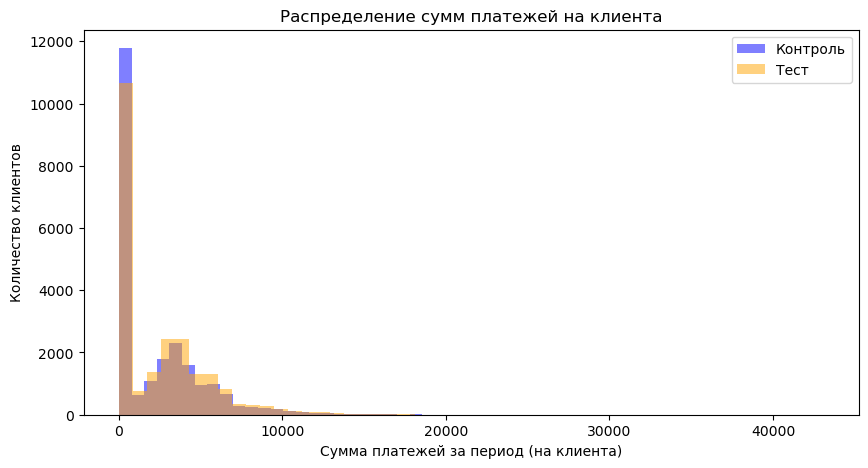

In [15]:
# 5.2. Гистограмма сумм платежей на клиента по группам

test_vals = ab_filtered.loc[ab_filtered["nflag_test"] == 1, "sum_payment"]
control_vals = ab_filtered.loc[ab_filtered["nflag_test"] == 0, "sum_payment"]

plt.figure(figsize=(10,5))
plt.hist(control_vals, bins=50, alpha=0.5, label="Контроль", color="blue")
plt.hist(test_vals, bins=50, alpha=0.5, label="Тест", color="orange")
plt.title("Распределение сумм платежей на клиента")
plt.xlabel("Сумма платежей за период (на клиента)")
plt.ylabel("Количество клиентов")
plt.legend()
plt.show()

In [16]:
# 5.3. Сравнение сумм платежей (тест vs контроль)
test_vals = ab_filtered.loc[ab_filtered["nflag_test"] == 1, "sum_payment"]
control_vals = ab_filtered.loc[ab_filtered["nflag_test"] == 0, "sum_payment"]

print("Сумма платежей — t-тест:")
t_sum, p_sum = test_calc(test_vals, control_vals)

print("\nСумма платежей — Манна–Уитни:")
mw_sum, p_mw_sum = mann_whitney_func(test_vals, control_vals)

# 5.4. Сравнение конверсии (paid_flag)
test_conv = ab_filtered.loc[ab_filtered["nflag_test"] == 1, "paid_flag"]
control_conv = ab_filtered.loc[ab_filtered["nflag_test"] == 0, "paid_flag"]

print("\nКонверсия — t-тест:")
t_conv, p_conv = test_calc(test_conv, control_conv)

# Итоговая сводка
print("\nИтоговые сводные значения:")
print(
    f"Средняя сумма: TEST={test_vals.mean():.2f}, CTRL={control_vals.mean():.2f}; "
    f"p_t={p_sum:.3g}, p_MW={p_mw_sum:.3g}"
)
print(
    f"Конверсия:     TEST={test_conv.mean():.3f}, CTRL={control_conv.mean():.3f}; "
    f"p_t={p_conv:.3g}"
)


Сумма платежей — t-тест:
Есть статистически значимая разница средних (p=4.41e-21)

Сумма платежей — Манна–Уитни:
Есть статистически значимые различия распределений (p=6.427e-24)

Конверсия — t-тест:
Есть статистически значимая разница средних (p=5.304e-20)

Итоговые сводные значения:
Средняя сумма: TEST=2446.70, CTRL=2186.10; p_t=4.41e-21, p_MW=6.43e-24
Конверсия:     TEST=0.542, CTRL=0.499; p_t=5.3e-20


**Общий вывод**

Анализ результатов A/B-теста после очистки данных показал:

Средняя сумма покупок на клиента
Контрольная группа: 2186.10
Тестовая группа: 2446.70

*Разница ≈ +260 руб. в тестовой группе*

И t-тест (p=4.41e-21), и критерий Манна–Уитни (p=6.43e-24) подтвердили, что различия статистически значимы.
Конверсия (доля клиентов, совершивших хотя бы одну покупку)
Контрольная группа: 49.9%
Тестовая группа: 54.2%

*Разница ≈ +4.3 п.п. в тестовой группе*

**t-тест (p=5.30e-20) показал, что различия статистически значимы.**

***Итог: новый маркетинговый инструмент — пуш-уведомления — привёл к существенному росту как среднего чека на клиента, так и конверсии. Полученные эффекты статистически значимы и подтверждены разными тестами.***

In [17]:
# 6. Сегментация результатов A/B-теста

def ab_summary(df, city_name):
    """
    Считает средние суммы и конверсии по тесту и контролю для заданного города
    + применяет t-тест и Манна–Уитни.
    """
    test_vals = df.loc[df["nflag_test"] == 1, "sum_payment"]
    control_vals = df.loc[df["nflag_test"] == 0, "sum_payment"]

    test_conv = df.loc[df["nflag_test"] == 1, "paid_flag"]
    control_conv = df.loc[df["nflag_test"] == 0, "paid_flag"]

    print(f"\n=== {city_name} ===")
    print("Сумма платежей — t-тест:")
    test_calc(test_vals, control_vals)

    print("Сумма платежей — Манна–Уитни:")
    mann_whitney_func(test_vals, control_vals)

    print("Конверсия — t-тест:")
    test_calc(test_conv, control_conv)

    print(f"Средняя сумма: TEST={test_vals.mean():.2f}, CTRL={control_vals.mean():.2f}")
    print(f"Конверсия:     TEST={test_conv.mean():.3f}, CTRL={control_conv.mean():.3f}")


# Москва
moscow_df = ab_filtered[ab_filtered["city"].str.lower() == "москва"]
ab_summary(moscow_df, "Москва")

# Санкт-Петербург
spb_df = ab_filtered[ab_filtered["city"].str.lower().str.contains("петербург")]
ab_summary(spb_df, "Санкт-Петербург")



=== Москва ===
Сумма платежей — t-тест:
Есть статистически значимая разница средних (p=3.236e-15)
Сумма платежей — Манна–Уитни:
Есть статистически значимые различия распределений (p=8.651e-17)
Конверсия — t-тест:
Есть статистически значимая разница средних (p=1.343e-10)
Средняя сумма: TEST=2379.23, CTRL=1986.18
Конверсия:     TEST=0.546, CTRL=0.488

=== Санкт-Петербург ===
Сумма платежей — t-тест:
Есть статистически значимая разница средних (p=2.304e-18)
Сумма платежей — Манна–Уитни:
Есть статистически значимые различия распределений (p=2.039e-20)
Конверсия — t-тест:
Есть статистически значимая разница средних (p=1.066e-20)
Средняя сумма: TEST=2427.46, CTRL=1913.56
Конверсия:     TEST=0.547, CTRL=0.448


In [18]:
# 6.3. Анализ остальных городов

other_cities = ab_filtered.loc[
    ~ab_filtered["city"].str.lower().isin(["москва", "санкт-петербург"])
, "city"].unique()

rows = []

for city in sorted(other_cities):
    df_city = ab_filtered[ab_filtered["city"] == city]
    
    test_vals = df_city.loc[df_city["nflag_test"] == 1, "sum_payment"]
    control_vals = df_city.loc[df_city["nflag_test"] == 0, "sum_payment"]

    test_conv = df_city.loc[df_city["nflag_test"] == 1, "paid_flag"]
    control_conv = df_city.loc[df_city["nflag_test"] == 0, "paid_flag"]

    t_stat, p_t_sum = test_calc(test_vals, control_vals)
    mw_stat, p_mw = mann_whitney_func(test_vals, control_vals)
    t_conv, p_t_conv = test_calc(test_conv, control_conv)

    rows.append({
        "city": city,
        "n_test": len(test_vals),
        "n_control": len(control_vals),
        "mean_sum_test": test_vals.mean(),
        "mean_sum_control": control_vals.mean(),
        "diff_sum": test_vals.mean() - control_vals.mean(),
        "conv_test": test_conv.mean(),
        "conv_control": control_conv.mean(),
        "p_t_sum": p_t_sum,
        "p_mw_sum": p_mw,
        "p_t_conv": p_t_conv
    })

city_results = pd.DataFrame(rows).sort_values("city")
city_results.head(10)


Статистически значимой разницы средних не обнаружено (p=0.8242)
Различий распределений не обнаружено (p=0.8162)
Статистически значимой разницы средних не обнаружено (p=0.6285)
Есть статистически значимая разница средних (p=0.01097)
Есть статистически значимые различия распределений (p=0.03167)
Статистически значимой разницы средних не обнаружено (p=0.08469)
Есть статистически значимая разница средних (p=0.03653)
Есть статистически значимые различия распределений (p=0.03324)
Статистически значимой разницы средних не обнаружено (p=0.1051)
Статистически значимой разницы средних не обнаружено (p=0.7397)
Различий распределений не обнаружено (p=0.7423)
Статистически значимой разницы средних не обнаружено (p=0.7421)
Статистически значимой разницы средних не обнаружено (p=0.279)
Различий распределений не обнаружено (p=0.372)
Статистически значимой разницы средних не обнаружено (p=0.7848)
Статистически значимой разницы средних не обнаружено (p=0.08548)
Различий распределений не обнаружено (p=0.

,city,n_test,n_control,mean_sum_test,mean_sum_control,diff_sum,conv_test,conv_control,p_t_sum,p_mw_sum,p_t_conv
0,Великий Новгород,124,107,1384.629032,1315.981308,68.647724,0.306452,0.336449,8.242488e-01,8.162137e-01,6.285459e-01
1,Владимир,509,608,2547.220039,2108.610197,438.609842,0.550098,0.498355,1.097240e-02,3.166761e-02,8.468968e-02
2,Волгоград,657,703,2288.870624,2601.761024,-312.890400,0.552511,0.596017,3.652898e-02,3.323940e-02,1.051467e-01
3,Дмитров,78,71,579.333333,483.450704,95.882629,0.115385,0.098592,7.396958e-01,7.422552e-01,7.421383e-01
4,Казань,2500,2577,2733.942000,2610.688397,123.253603,0.478800,0.474971,2.790466e-01,3.719950e-01,7.848309e-01
5,Краснодар,1024,1139,2696.804688,2912.431080,-215.626392,0.614258,0.653205,8.548424e-02,5.938102e-02,6.069556e-02
6,Красноярск,3037,2900,2437.495884,2428.777586,8.718298,0.557787,0.561379,9.044395e-01,8.770470e-01,7.805294e-01
7,Мурманск,1055,1065,1865.271090,1857.219718,8.051372,0.436967,0.418779,9.449722e-01,5.434252e-01,3.976543e-01
8,Нижний Новгород,142,150,1970.549296,2336.186667,-365.637371,0.443662,0.533333,2.381637e-01,1.686146e-01,1.263347e-01
9,Самара,802,846,3262.789277,1718.417258,1544.372019,0.716958,0.439716,3.234376e-29,4.325202e-30,2.857154e-31


*Москва*

Средняя сумма на клиента: в тестовой группе выше, чем в контрольной.
Конверсия: в тестовой группе также выше.

Различия статистически значимы по обеим метрикам (и t-тест, и Манна–Уитни).
**Вывод: пуш-уведомления в Москве работают эффективнее, чем баннеры.**

*Санкт-Петербург*

Средняя сумма на клиента в тесте выше, чем в контроле.
Конверсия также лучше в тестовой группе.

Различия статистически значимы.
**Вывод: эффект пуш-уведомлений положителен и воспроизводим в Санкт-Петербурге.**

*Другие города*

При анализе каждого города отдельно результаты оказались разнообразными:
В ряде городов выявлен положительный эффект (тест > контроль, различия значимы).
В некоторых городах эффект нейтрален (различия статистически незначимы).
Отрицательных эффектов почти не наблюдается, но локально встречаются города без уверенного прироста.

**Общий вывод: в крупнейших городах (Москва, СПб) эффект положительный и значимый, а в регионах картина менее однородная: есть города с ростом метрик, есть нейтральные сегменты. Это важно учитывать при масштабировании механики — эффект в целом положителен, но сила эффекта может зависеть от региона.**

In [19]:
# 7. Отчёт по A/B-тесту: расчёт метрик по ТТ, коррекция p-value, лейблы

import numpy as np

alpha = 0.05
total_clients = len(ab_filtered)

rows = []

for (city, tp), g in ab_filtered.groupby(["city", "id_trading_point"], sort=False):
    test_vals = g.loc[g["nflag_test"] == 1, "sum_payment"].values
    ctrl_vals = g.loc[g["nflag_test"] == 0, "sum_payment"].values
    n_test, n_ctrl = test_vals.size, ctrl_vals.size
    if n_test < 2 or n_ctrl < 2:
        continue  

    # Основные метрики
    m_test = test_vals.mean()
    m_ctrl = ctrl_vals.mean()
    diff   = m_test - m_ctrl
    s_test = test_vals.std(ddof=1)
    s_ctrl = ctrl_vals.std(ddof=1)

    # Welch t-test (двусторонний)
    t_stat, p_val = ttest_ind(test_vals, ctrl_vals, equal_var=False)

    rows.append((
        city, tp, n_test, n_ctrl, n_test + n_ctrl,
        (n_test + n_ctrl) / total_clients * 100.0,
        m_test, m_ctrl, diff, s_test, s_ctrl, t_stat, p_val
    ))

by_tp = pd.DataFrame(rows, columns=[
    "city","id_trading_point","count_test","count_control","count_all",
    "percent_count","avg_payment_test","avg_payment_control","diff",
    "sigma_test","sigma_control","ttest","pvalue_ttest"
])

by_tp["label"] = np.where(
    (by_tp["diff"] > 0) & (by_tp["pvalue_ttest"] < alpha), "positive",
    np.where((by_tp["diff"] < 0) & (by_tp["pvalue_ttest"] < alpha), "negative", "neutral")
)

# форматирование
round2 = ["avg_payment_test","avg_payment_control","diff","sigma_test","sigma_control","percent_count"]
by_tp[round2] = by_tp[round2].round(2)

by_tp["pvalue_ttest"] = by_tp["pvalue_ttest"].map(lambda x: float(f"{x:.4g}"))

# контроль лейблов
display(by_tp["label"].value_counts())
by_tp.head(10)


label
neutral     33
positive    17
negative     3
Name: count, dtype: int64

,city,id_trading_point,count_test,count_control,count_all,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,ttest,pvalue_ttest,label
0,Красноярск,212,593,575,1168,2.55,2144.32,2222.05,-77.74,2708.59,2785.12,-0.483378,6.289000e-01,neutral
1,Нижний Новгород,13,142,150,292,0.64,1970.55,2336.19,-365.64,2575.94,2709.90,-1.182026,2.382000e-01,neutral
2,Мурманск,54,633,640,1273,2.78,1702.71,1688.51,14.20,2565.13,2628.01,0.097569,9.223000e-01,neutral
3,Казань,991,270,294,564,1.23,3249.28,2452.99,796.30,4719.59,3633.94,2.230816,2.613000e-02,positive
4,Санкт-Петербург,453,1066,1049,2115,4.61,2501.97,1889.92,612.04,2993.44,2648.66,4.981786,6.817000e-07,positive
5,Москва,2652,2273,2370,4643,10.13,2508.89,1972.85,536.04,2846.64,2565.88,6.730570,1.900000e-11,positive
6,Красноярск,278,535,489,1024,2.23,2499.35,2185.21,314.13,2916.00,2574.92,1.830426,6.748000e-02,neutral
7,Москва,6543,662,689,1351,2.95,1715.49,1528.33,187.16,2457.37,2338.52,1.432978,1.521000e-01,neutral
8,Казань,699,482,494,976,2.13,2422.29,2574.35,-152.07,3906.82,4082.85,-0.594576,5.523000e-01,neutral
9,Казань,477,382,386,768,1.68,2259.62,2496.99,-237.36,3482.85,3881.99,-0.892096,3.726000e-01,neutral


In [20]:
# Экспорт в Excel
out_path = "ab_report_final.xlsx"

with pd.ExcelWriter(out_path) as writer:
    by_tp.to_excel(writer, sheet_name="all", index=False)
    by_tp[by_tp["label"]=="positive"].to_excel(writer, sheet_name="positive", index=False)
    by_tp[by_tp["label"]=="negative"].to_excel(writer, sheet_name="negative", index=False)
    by_tp[by_tp["label"]=="neutral"].to_excel(writer, sheet_name="neutral", index=False)

out_path


'ab_report_final.xlsx'